In [1]:
import numpy
import plotly.offline
import scipy
import pandas
import matplotlib.pyplot as plt
import sklearn
import plotly.graph_objects as go
import plotly.express as px
import plotly

In [2]:
df = pandas.read_csv('AAPL.csv')
df = df[['Date', 'Close']]
df.Date = pandas.to_datetime(df['Date'], format='%Y-%m-%d')
# pandas may work weird with dates
df = df[df['Date'] >= pandas.to_datetime('2017-01-01', format='%Y-%m-%d')]  # consider only after 2017
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(df.Date), y=list(df.Close)))
# Set title
fig.update_layout(
    title_text="AAPL Closing Price"
)
# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

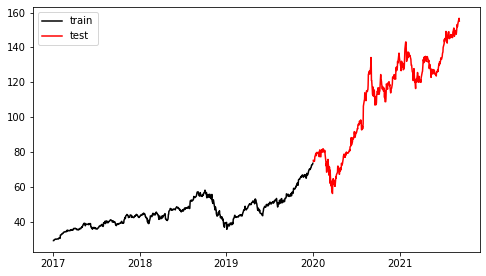

In [3]:
train_df = df[pandas.to_datetime(df['Date'], format='%Y-%m-%d') < pandas.to_datetime('2020-01-01', format='%Y-%m-%d')]
test_df = df[pandas.to_datetime(df['Date'], format='%Y-%m-%d') > pandas.to_datetime('2019-12-31', format='%Y-%m-%d')]

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(train_df.Date, train_df.Close, color='black', label='train')
ax.plot(test_df.Date, test_df.Close, color='red', label='test')
ax.legend(loc='best')
fig.show()

## LSTM

Let's use LSTM to forecast the stock price:

In [4]:
# necessary imports
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.utils import plot_model

# seed
numpy.random.seed(7)

Since LSTM's consider a sequential data, we'll have to provide the previous period as a predictor for the current period. We'll also normalize the prices, don't forget to keep train/test sets separate while normalizing.

In [5]:
train_X = numpy.array(train_df.Close)[:-1]  # exclude the last one
train_Y = numpy.array(train_df.Close)[1:]  # exclude the first one
# doing it manually to be able to convert values back
# X
train_X_std = (train_X - train_X.min()) / (
    train_X.max() - train_X.min())
train_X_scaled = train_X_std * (1 - 0) + 0  # train_X_std * (max - min) + min
# Y
train_Y_std = (train_Y - train_X.min()) / (
    train_X.max() - train_X.min())
train_Y_scaled = train_Y_std * (1 - 0) + 0  # train_Y_std * (max - min) + min
print(f'Scaled values: {train_X_scaled[:5]}')
# combining X and Y:
train_df_lstm = pandas.DataFrame(numpy.array([train_X_scaled, train_Y_scaled]).T,
                                 columns=['X', 'Y'], index=train_df.Date[:-1])
print(train_df_lstm.head())
# preparing the test data:
test_X = numpy.array(test_df.Close)[:-1]  # exclude the last one
test_Y = numpy.array(test_df.Close)[1:]  # exclude the first one
test_X_std = (test_X - train_X.min()) / (
    train_X.max() - train_X.min())
test_X_scaled = test_X_std * (1 - 0) + 0
test_Y_std = (test_Y - train_X.min()) / (
    train_X.max() - train_X.min())
test_Y_scaled = test_Y_std * (1 - 0) + 0
test_df_lstm = pandas.DataFrame(numpy.array([test_X_scaled, test_Y_scaled]).T,
                                 columns=['X', 'Y'], index=test_df.Date[:-1])

Scaled values: [0.00074076 0.         0.00336185 0.01076928 0.01692308]
                   X         Y
Date                          
2017-01-03  0.000741  0.000000
2017-01-04  0.000000  0.003362
2017-01-05  0.003362  0.010769
2017-01-06  0.010769  0.016923
2017-01-09  0.016923  0.017607


Creating an LSTM model and training it:

In [6]:
model = Sequential()
# adding layers and dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, 1)))  # (num_input, num_next)
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# adding the output layer, number of outputs is 1
model.add(Dense(units=1))

# compile and train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_df_lstm['X'], train_df_lstm['Y'], epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 18s 9ms/step - loss: 0.1513
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0638
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0286
Epoch 4/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0213
Epoch 5/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0115
Epoch 6/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0057
Epoch 7/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0047
Epoch 8/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 9/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0045
Epoch 10/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0036
Epoch 11/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0037
Epoch 12/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0035
Epoch 13/100
24/24 [===========

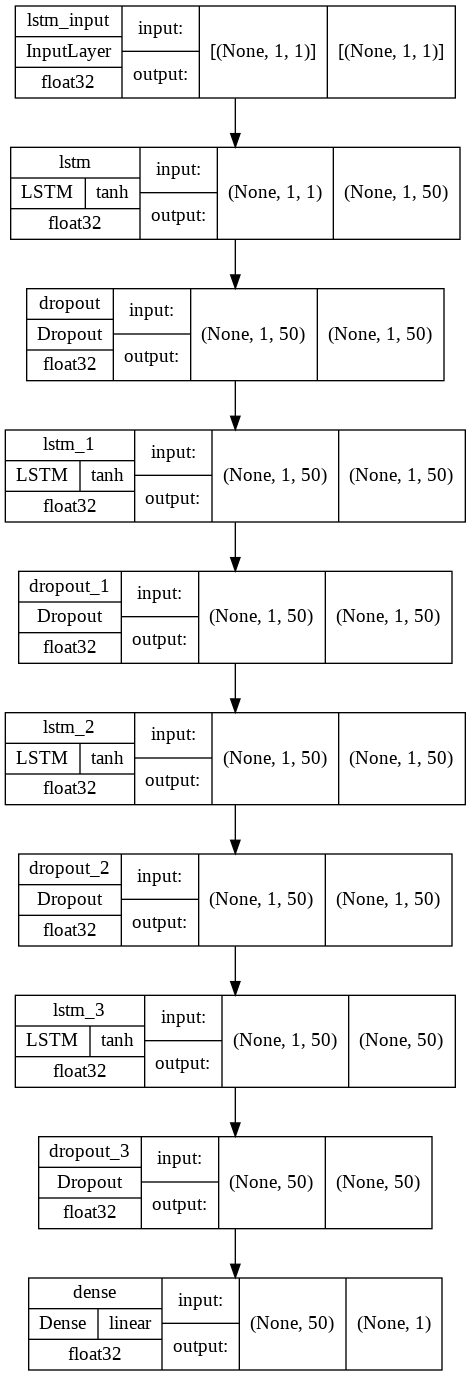

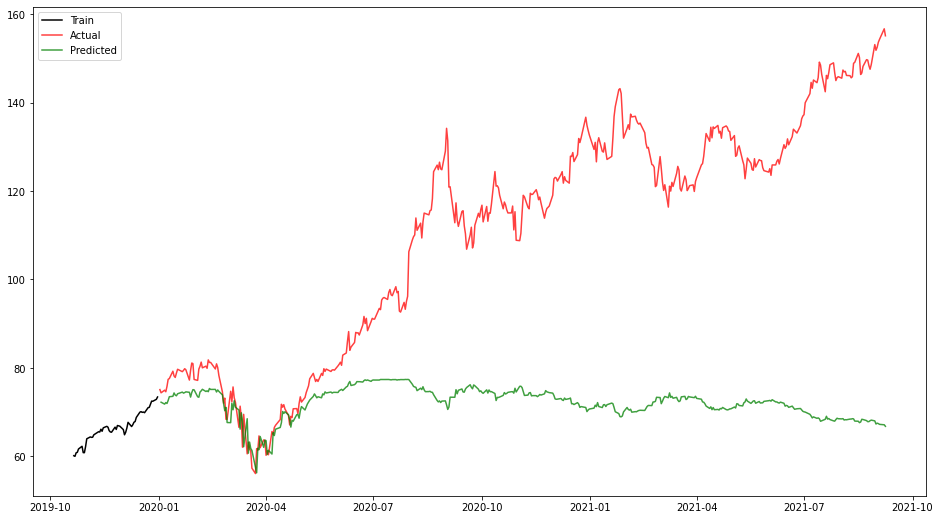

In [11]:
predicted_stock_price = model.predict(test_df_lstm['X'])
# converting back
predicted_stock_price = predicted_stock_price * (train_X.max() - train_X.min())\
                         + train_X.min()
# visualizing
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(train_df.Date[-50:], train_df.Close[-50:], color='black', label='Train')
ax.plot(test_df.Date, test_df.Close, color='red', label='Actual',alpha=0.75)
ax.plot(test_df.Date[1:], predicted_stock_price, color='green',
        label='Predicted', alpha=0.75)
ax.legend(loc='best')
fig.show()

# neural network
plot_model(model, to_file='network.png', show_shapes=True,
           show_dtype=True, show_layer_names=True,
           rankdir="TB", expand_nested=True,
           dpi=96, layer_range=None,
           show_layer_activations=True,)